This is a test notebook for the Gaussian Diffusion peptide project. To test if the model is working, I will give it a synthetic dataset (a sin wave) and check if the diffusion model can diffuse into that:

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn
import time

from torch.utils.data import DataLoader, TensorDataset
from guided_diffusion_1d import Unet1D, GaussianDiffusion1D
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

True


In [ ]:
SEQ_LENGTH = 128 # number of entries in the latent
FREQ_THRESH = 10

In [5]:
# Creates the synthetic dataset which is just a bunch of sin waves
def create_wave(freq, phase, seq_length):
    # creates a wave with freq, phase, and seq_length (the number of samples in the wave)
    t = np.linspace(0, 1, seq_length)

    # normalizes wave to [0, 1]
    latent = ((np.sin(freq * t + phase) / 2) + 0.5).reshape(-1, seq_length) 
    return torch.tensor(latent, dtype=torch.float32)

def is_high_frequency(freq):
    return 1 if freq >= FREQ_THRESH else 0

class SyntheticDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=128):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.create_dataset()

    def create_dataset(self):
        self.latents = []
        self.freqs = []
        self.labels = []

        # creates num_sample random sin waves
        for _ in range(self.num_samples):
            freq = np.random.uniform(6, 40.0)
            phase = np.random.uniform(0, 2 * np.pi)
            self.latents.append(create_wave(freq, phase, self.seq_length))
            self.freqs.append(freq)
            self.labels.append(is_high_frequency(freq))

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx]            
    
    def get_latents(self):
        return self.latents
    
    def get_freq(self, idx):
        return self.freqs[idx]

In [6]:
def plot_latent(x):
    z = x.reshape(-1)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.linspace(0, 1, SEQ_LENGTH), z, 'b-', linewidth=2)

def plot_sample(samples, num_samples=4):
        b, c, n = samples.shape
        
        # Plot the samples
        plt.figure(figsize=(12, 8))
        for i in range(num_samples):
            plt.subplot(num_samples, 1, i+1)
            plt.plot(np.linspace(0, 1, n), samples[i, 0].cpu().numpy())
            plt.title(f"Sample {i+1}")
            plt.ylim(0, 1.1)
        plt.tight_layout()
    

Freq: 37.60636986710507, Label: 1
Freq: 24.806624056636423, Label: 1
Freq: 21.93232235292863, Label: 1
Freq: 18.76440591269335, Label: 1


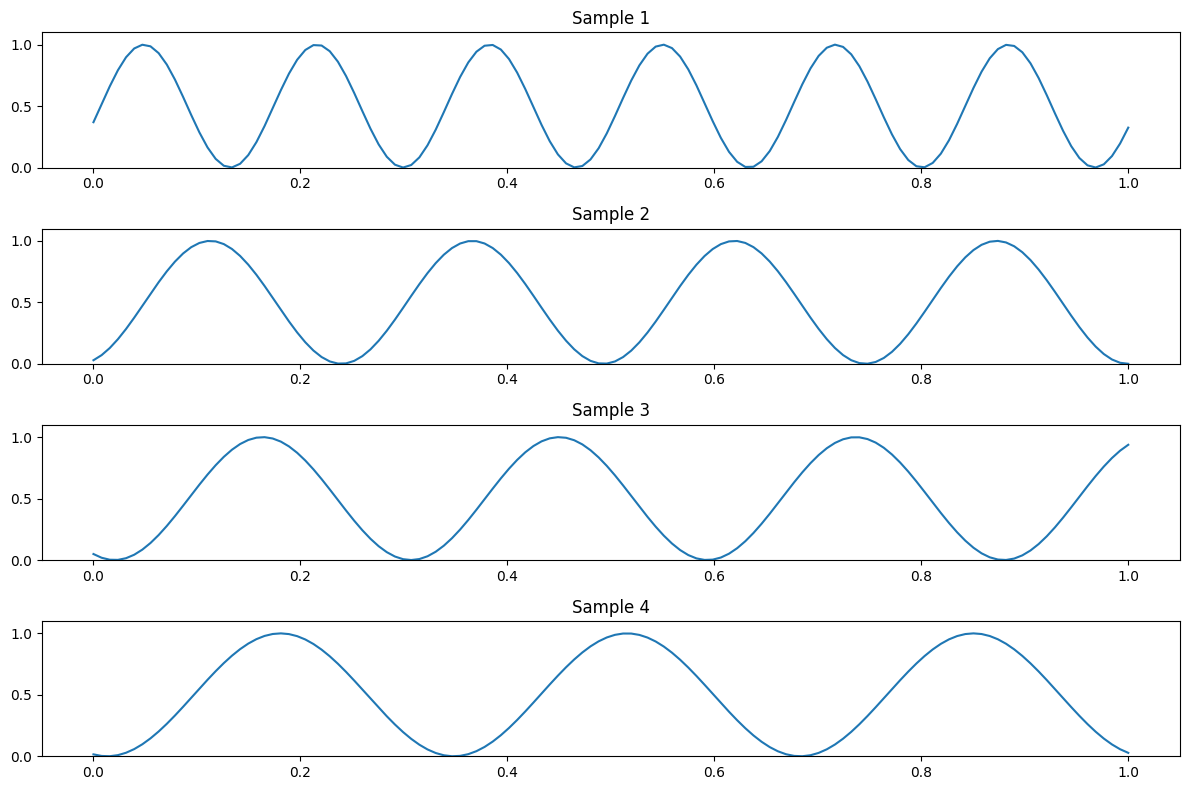

In [7]:
dataset = SyntheticDataset(num_samples=1000, seq_length=128)
samples = torch.stack([dataset.latents[i] for i in range(4)])
plot_sample(samples=samples, num_samples=4)
for i in range(4):
    print(f"Freq: {dataset.freqs[i]}, Label: {dataset.labels[i]}")

In [22]:
def train_diffusion(model, dataset, batch_size=16, epochs=10, lr=1e-4):
    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            
            optimizer.zero_grad()
            loss = model(batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}")
        
        avg_loss = epoch_loss / len(dataloader)
        elapsed = time.time() - start_time
        print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.6f}, Time: {elapsed:.2f}s")

        # model.eval()
        # with torch.no_grad():
        #     samples = model.sample(batch_size=4)
        #     plot_sample(samples)



In [17]:
def test_classifier(classifier):
    dataset = SyntheticDataset(num_samples=1000, seq_length=128)

    succ = 0
    classifier.eval()
    for i in range(1000):
        latent_tensor = dataset.latents[i].reshape(1, 1, SEQ_LENGTH).to(device)
        prob = torch.sigmoid(classifier(latent_tensor))
        if (prob[0].item() >= 0.5) == (dataset.labels[i]):
            succ += 1
    print(f"Correctness: {succ / 1000}")
    

In [11]:
class SimpleClassifier(nn.Module):
    def __init__(self, channels=1, seq_length=128):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (seq_length // 4), 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classifier (high/low frequency)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)

def train_classifier(dataset : SyntheticDataset, seq_length=128, channels=1, batch_size=16, epochs=50):
    
    # Create dataloader


    latents = torch.stack(dataset.latents)
    dataset = TensorDataset(latents.float(), torch.tensor(dataset.labels).float())  # Changed to stack scalars
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # classifier
    classifier = SimpleClassifier(channels=channels, seq_length=seq_length)
    
    # optimizer
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    
    # train classifier loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    classifier.to(device)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = classifier(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Classifier Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")
        # test_classifier(classifier)


    
    return classifier


dataset = SyntheticDataset(num_samples=1000, seq_length=128)
classifier = train_classifier(dataset, seq_length=128, channels=1)

Classifier Epoch 1/50, Loss: 0.434443
Classifier Epoch 2/50, Loss: 0.347909
Classifier Epoch 3/50, Loss: 0.342974
Classifier Epoch 4/50, Loss: 0.339136
Classifier Epoch 5/50, Loss: 0.333531
Classifier Epoch 6/50, Loss: 0.327182
Classifier Epoch 7/50, Loss: 0.320342
Classifier Epoch 8/50, Loss: 0.312548
Classifier Epoch 9/50, Loss: 0.303349
Classifier Epoch 10/50, Loss: 0.292667
Classifier Epoch 11/50, Loss: 0.276838
Classifier Epoch 12/50, Loss: 0.260326
Classifier Epoch 13/50, Loss: 0.241213
Classifier Epoch 14/50, Loss: 0.221591
Classifier Epoch 15/50, Loss: 0.203833
Classifier Epoch 16/50, Loss: 0.185060
Classifier Epoch 17/50, Loss: 0.165562
Classifier Epoch 18/50, Loss: 0.152146
Classifier Epoch 19/50, Loss: 0.137568
Classifier Epoch 20/50, Loss: 0.124008
Classifier Epoch 21/50, Loss: 0.113852
Classifier Epoch 22/50, Loss: 0.110912
Classifier Epoch 23/50, Loss: 0.097964
Classifier Epoch 24/50, Loss: 0.090570
Classifier Epoch 25/50, Loss: 0.090574
Classifier Epoch 26/50, Loss: 0.07

In [18]:
test_classifier(classifier)

Correctness: 0.992


Using device: cuda


sampling loop time step: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 0, Batch 0, Loss: 0.440887
Epoch 0, Batch 10, Loss: 0.187718
Epoch 0, Batch 20, Loss: 0.153767
Epoch 0, Batch 30, Loss: 0.173999
Epoch 0, Batch 40, Loss: 0.201862
Epoch 0, Batch 50, Loss: 0.120564
Epoch 0, Batch 60, Loss: 0.134813
Epoch 0 completed. Avg Loss: 0.199916, Time: 3.51s
Epoch 1, Batch 0, Loss: 0.136404
Epoch 1, Batch 10, Loss: 0.139179
Epoch 1, Batch 20, Loss: 0.110532
Epoch 1, Batch 30, Loss: 0.119965
Epoch 1, Batch 40, Loss: 0.101848
Epoch 1, Batch 50, Loss: 0.119304
Epoch 1, Batch 60, Loss: 0.086065
Epoch 1 completed. Avg Loss: 0.110988, Time: 3.25s
Epoch 2, Batch 0, Loss: 0.097236
Epoch 2, Batch 10, Loss: 0.070190
Epoch 2, Batch 20, Loss: 0.067604
Epoch 2, Batch 30, Loss: 0.077559
Epoch 2, Batch 40, Loss: 0.082521
Epoch 2, Batch 50, Loss: 0.073899
Epoch 2, Batch 60, Loss: 0.068689
Epoch 2 completed. Avg Loss: 0.084879, Time: 3.28s
Epoch 3, Batch 0, Loss: 0.078436
Epoch 3, Batch 10, Loss: 0.072507
Epoch 3, Batch 20, Loss: 0.052941
Epoch 3, Batch 30, Loss: 0.080962
E

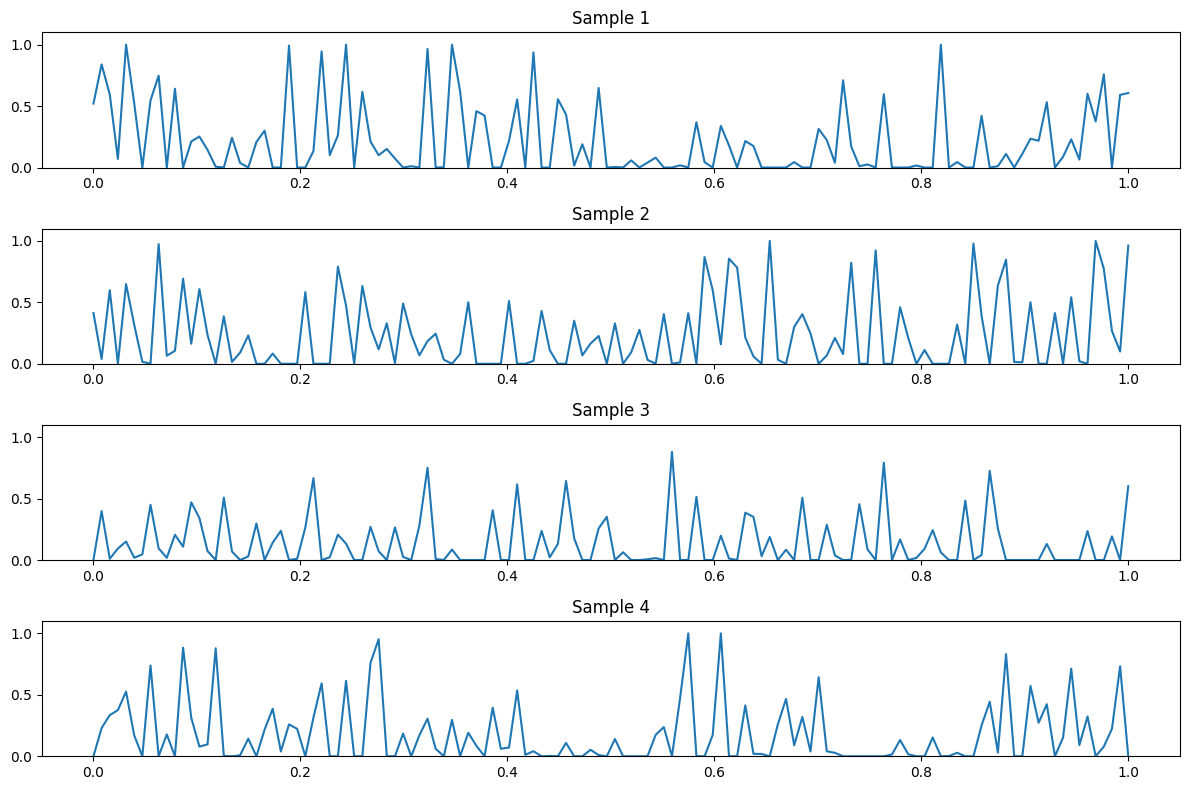

In [24]:
batch_size = 16
num_datapoints = 1000
epochs = 8
seq_length = SEQ_LENGTH

print(f"Using device: {device}")
dataset = SyntheticDataset(num_samples=num_datapoints, seq_length=seq_length)
# latents = torch.stack([torch.from_numpy(latent).float() for latent in dataset.latents])

model = Unet1D(
    dim=128,
    channels=1,
    dim_mults=(1, 2, 4)
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length=seq_length,
    timesteps=100,
    objective='pred_v'
)

# see what it looks like before training
with torch.no_grad():
    model.eval()
    samples = diffusion.sample(batch_size=4)
    plot_sample(samples)
train_diffusion(diffusion, dataset, epochs=epochs)


In [ ]:
    
# def classifier_guidance_fn(x, t, classifier, guidance_scale=1.0):
#     """
#         Compute the gradient of the classifier score with respect to x
#     """
#     x.requires_grad_(True)
#     score = classifier(x)
#     grad = torch.autograd.grad(score.sum(), x)[0]

#     return guidance_scale * grad

sampling loop time step:   6%|▌         | 6/100 [00:00<00:01, 58.20it/s]

gradient:  tensor(0.0002, device='cuda:0')
gradient:  tensor(0.0065, device='cuda:0')
gradient:  tensor(-0.1038, device='cuda:0')
gradient:  tensor(-0.0558, device='cuda:0')
gradient:  tensor(0.0107, device='cuda:0')
gradient:  tensor(-0.0029, device='cuda:0')
gradient:  tensor(0.0210, device='cuda:0')
gradient:  tensor(0.0151, device='cuda:0')
gradient:  tensor(0.0253, device='cuda:0')
gradient:  tensor(0.0243, device='cuda:0')
gradient:  tensor(0.0213, device='cuda:0')
gradient:  tensor(0.0200, device='cuda:0')


sampling loop time step:  18%|█▊        | 18/100 [00:00<00:01, 55.72it/s]

gradient:  tensor(0.0208, device='cuda:0')
gradient:  tensor(0.0162, device='cuda:0')
gradient:  tensor(0.0152, device='cuda:0')
gradient:  tensor(0.0169, device='cuda:0')
gradient:  tensor(0.0199, device='cuda:0')
gradient:  tensor(0.0160, device='cuda:0')
gradient:  tensor(0.0184, device='cuda:0')
gradient:  tensor(0.0127, device='cuda:0')
gradient:  tensor(0.0126, device='cuda:0')
gradient:  tensor(0.0170, device='cuda:0')
gradient:  tensor(0.0092, device='cuda:0')


sampling loop time step:  30%|███       | 30/100 [00:00<00:01, 56.60it/s]

gradient:  tensor(0.0101, device='cuda:0')
gradient:  tensor(0.0128, device='cuda:0')
gradient:  tensor(0.0116, device='cuda:0')
gradient:  tensor(0.0084, device='cuda:0')
gradient:  tensor(0.0091, device='cuda:0')
gradient:  tensor(0.0085, device='cuda:0')
gradient:  tensor(0.0086, device='cuda:0')
gradient:  tensor(0.0058, device='cuda:0')
gradient:  tensor(0.0085, device='cuda:0')
gradient:  tensor(0.0091, device='cuda:0')
gradient:  tensor(0.0074, device='cuda:0')
gradient:  tensor(0.0104, device='cuda:0')
gradient:  tensor(0.0105, device='cuda:0')


sampling loop time step:  42%|████▏     | 42/100 [00:00<00:01, 56.68it/s]

gradient:  tensor(0.0102, device='cuda:0')
gradient:  tensor(0.0134, device='cuda:0')
gradient:  tensor(0.0121, device='cuda:0')
gradient:  tensor(0.0118, device='cuda:0')
gradient:  tensor(0.0109, device='cuda:0')
gradient:  tensor(0.0107, device='cuda:0')
gradient:  tensor(0.0101, device='cuda:0')
gradient:  tensor(0.0099, device='cuda:0')
gradient:  tensor(0.0089, device='cuda:0')
gradient:  tensor(0.0086, device='cuda:0')
gradient:  tensor(0.0108, device='cuda:0')


sampling loop time step:  54%|█████▍    | 54/100 [00:00<00:00, 56.76it/s]

gradient:  tensor(0.0087, device='cuda:0')
gradient:  tensor(0.0078, device='cuda:0')
gradient:  tensor(0.0075, device='cuda:0')
gradient:  tensor(0.0089, device='cuda:0')
gradient:  tensor(0.0076, device='cuda:0')
gradient:  tensor(0.0081, device='cuda:0')
gradient:  tensor(0.0086, device='cuda:0')
gradient:  tensor(0.0077, device='cuda:0')
gradient:  tensor(0.0085, device='cuda:0')
gradient:  tensor(0.0077, device='cuda:0')
gradient:  tensor(0.0066, device='cuda:0')
gradient:  tensor(0.0073, device='cuda:0')


sampling loop time step:  66%|██████▌   | 66/100 [00:01<00:00, 56.25it/s]

gradient:  tensor(0.0070, device='cuda:0')
gradient:  tensor(0.0073, device='cuda:0')
gradient:  tensor(0.0067, device='cuda:0')
gradient:  tensor(0.0067, device='cuda:0')
gradient:  tensor(0.0063, device='cuda:0')
gradient:  tensor(0.0058, device='cuda:0')
gradient:  tensor(0.0055, device='cuda:0')
gradient:  tensor(0.0057, device='cuda:0')
gradient:  tensor(0.0050, device='cuda:0')
gradient:  tensor(0.0055, device='cuda:0')
gradient:  tensor(0.0057, device='cuda:0')
gradient:  tensor(0.0049, device='cuda:0')
gradient:  

sampling loop time step:  78%|███████▊  | 78/100 [00:01<00:00, 56.42it/s]

tensor(0.0043, device='cuda:0')
gradient:  tensor(0.0043, device='cuda:0')
gradient:  tensor(0.0040, device='cuda:0')
gradient:  tensor(0.0039, device='cuda:0')
gradient:  tensor(0.0038, device='cuda:0')
gradient:  tensor(0.0038, device='cuda:0')
gradient:  tensor(0.0037, device='cuda:0')
gradient:  tensor(0.0035, device='cuda:0')
gradient:  tensor(0.0034, device='cuda:0')
gradient:  tensor(0.0034, device='cuda:0')
gradient:  tensor(0.0032, device='cuda:0')
gradient:  tensor(0.0031, device='cuda:0')


sampling loop time step:  90%|█████████ | 90/100 [00:01<00:00, 56.12it/s]

gradient:  tensor(0.0029, device='cuda:0')
gradient:  tensor(0.0028, device='cuda:0')
gradient:  tensor(0.0025, device='cuda:0')
gradient:  tensor(0.0025, device='cuda:0')
gradient:  tensor(0.0026, device='cuda:0')
gradient:  tensor(0.0023, device='cuda:0')
gradient:  tensor(0.0022, device='cuda:0')
gradient:  tensor(0.0021, device='cuda:0')
gradient:  tensor(0.0019, device='cuda:0')
gradient:  tensor(0.0018, device='cuda:0')
gradient:  tensor(0.0017, device='cuda:0')
gradient:  tensor(0.0017, device='cuda:0')


sampling loop time step: 100%|██████████| 100/100 [00:01<00:00, 56.63it/s]


gradient:  tensor(0.0016, device='cuda:0')
gradient:  tensor(0.0016, device='cuda:0')
gradient:  tensor(0.0014, device='cuda:0')
gradient:  tensor(0.0011, device='cuda:0')
gradient:  tensor(0., device='cuda:0')


sampling loop time step: 100%|██████████| 100/100 [00:01<00:00, 65.90it/s]


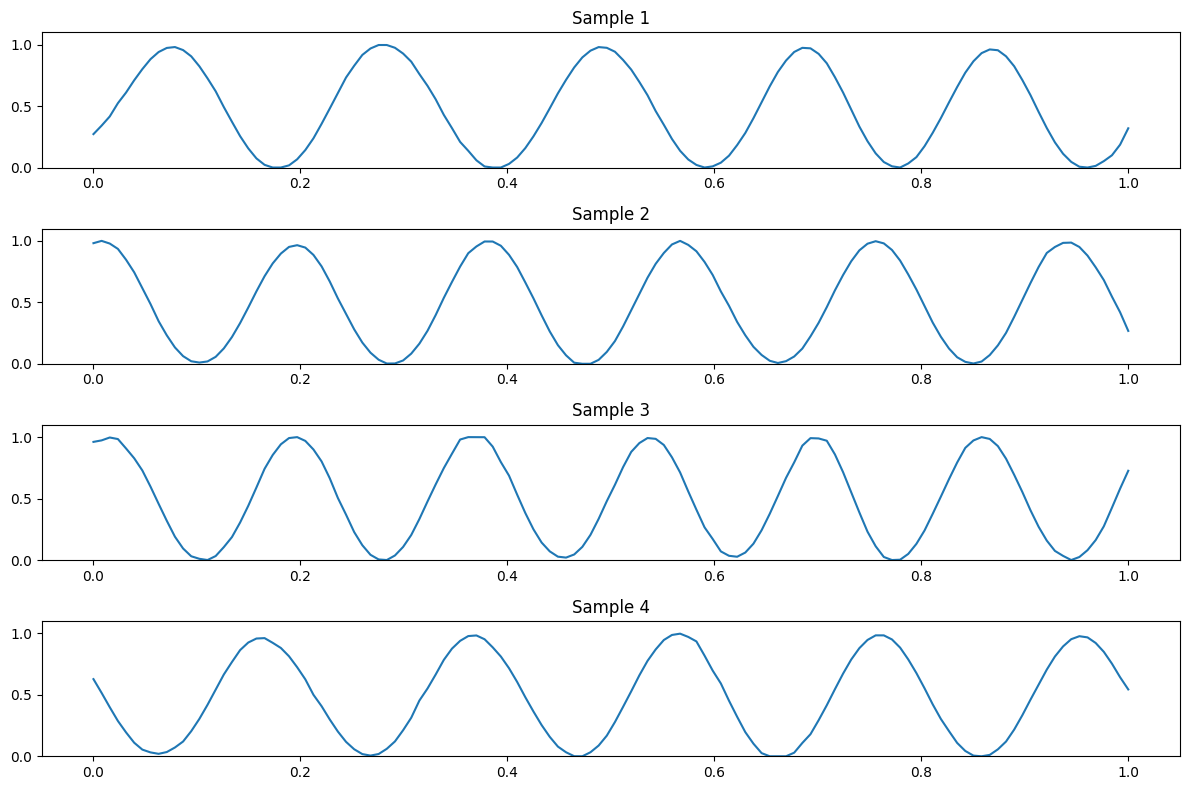

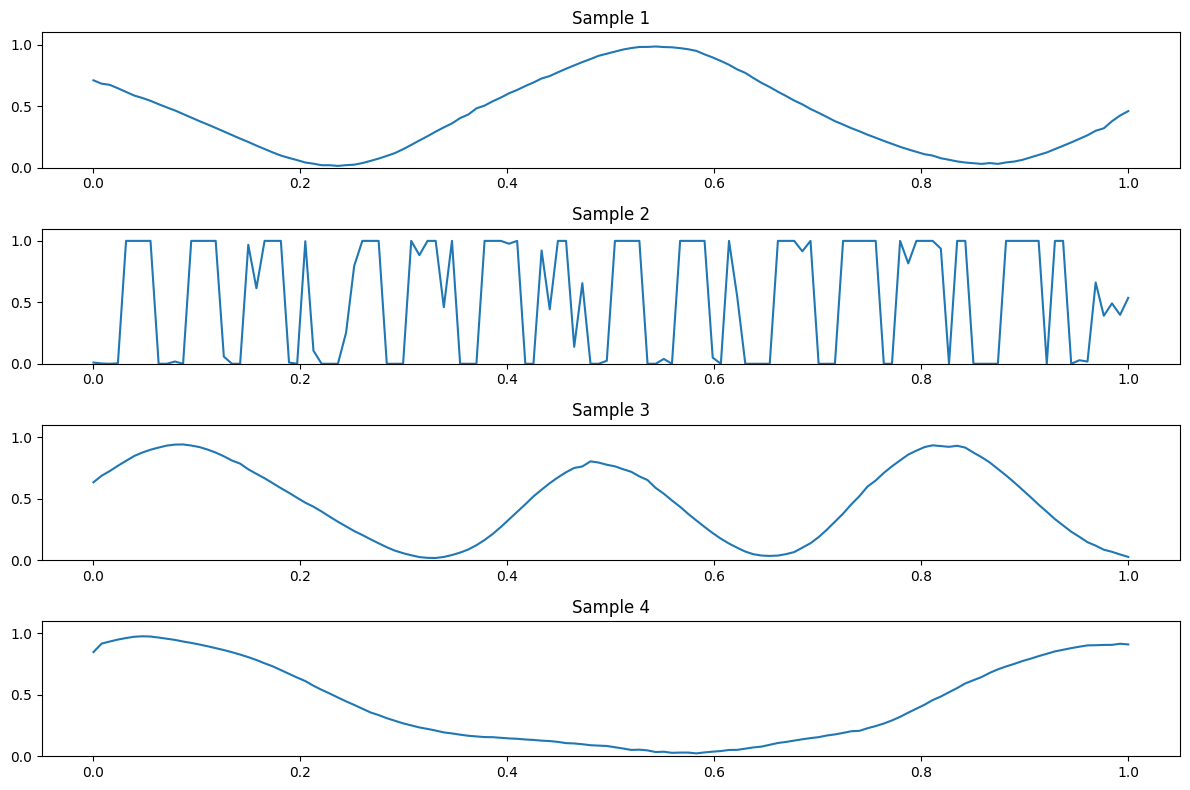

In [33]:
def sample_with_guidance(diffusion, classifier, guidance_scale=-4.0, batch_size=4, seq_length=128, channels=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create a partial function for guidance
    def cond_fn(x, t):
        with torch.enable_grad():
            y = torch.fill(torch.zeros(batch_size), 0).long()
            x_in = x.detach().requires_grad_(True)
            logits = classifier(x_in)
            log_probs = F.log_softmax(logits, dim = -1)
            selected = log_probs[range(len(logits))]
            grad = torch.autograd.grad(selected.sum(), x_in)[0] * guidance_scale
            return grad
        
    # Sample with guidance
    samples = diffusion.sample(
        batch_size=batch_size,
        cond_fn=cond_fn,
        guidance_kwargs={}
    )
    
    # Also generate samples without guidance for comparison
    with torch.no_grad():
        samples_no_guidance = diffusion.sample(batch_size=batch_size)
    
    return samples, samples_no_guidance
samples, samples_no_guidance = sample_with_guidance(diffusion, classifier)
plot_sample(samples_no_guidance)
plot_sample(samples)